<a href="https://colab.research.google.com/github/KyungRyeolBaek/study/blob/main/ds_sc23x.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS SC23x 
## Applied Predictive Modeling

 이번 스프린트 챌린지에서는 시카고에 있는 식당들의 정보와 해당 식당들의 위생 검사 결과에 관한 데이터를 담은 데이터셋을 다루게 됩니다.

데이터셋에 관한 설명은 이 [PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF)를 참고해주시길 바랍니다.

#### 오늘 여러분은 Chicago시의 공중보건부가 진행한 위생 검사의 실패 여부를 예측하는 모델을 만들어야 합니다.

여러분의 모델이 예측할 target은 `Inspection Fail` 칼럼입니다.   
칼럼 값은 아래와 같습니다:
- 식당이 위생 검사에 불합격한 경우: **1**
- 식당이 검사를 통과한 경우: **0**

In [1]:
# Google Colab을 사용하는 경우 해당 셀을 실행하세요
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

In [60]:
# 데이터셋을 불러오기 위해 판다스 라이브러리를 불러옵니다
import pandas as pd

train_url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_train.csv'
test_url  = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/food_inspection_sc23x/food_ins_test.csv'

# train, test 데이터셋을 불러옵니다
train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

# 데이터셋 확인
assert train.shape == (60000, 17)
assert test.shape  == (20000, 17)

# Part 1: 데이터 전처리 (Data Preprocessing)

In [3]:
## 1.1 데이터셋을 파악하기 위한 EDA를 진행하세요
# > EDA를 하는 방식 및 라이브러리에 대한 제한은 없습니다. 단, 시간 분배에 주의하세요.

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
!pip install category_encoders

In [2]:
# 이 곳에 답안을 작성해주시길 바랍니다
from pandas_profiling import ProfileReport
profile = ProfileReport(train, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
profile = ProfileReport(test, title="Pandas Profiling Report", explorative=True)
profile

Summarize dataset:   0%|          | 0/30 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# 데이터 프로파일링 결과
## Variable Types
- Numeric : 5 개
- Categorical : 12 개

## Dataset 특징
- Feature 개수 : 17 개
- 샘플 개수 : 60000 개 + 20000 개
- 결측치 개수 : 18649 개 + 6223 개

## Variables
- Inspection ID : Real number, unique
- DBA Name : Categorical, HIGH CARDINALITY
- AKA Name : Categorical, HIGH CARDINALITY, MISSING
- License # : Real number 
- Facility Type : Categorical, HIGH CARDINALITY, MISSING
- Risk : Categorical, HIGH CORRELATION(state)
- Address : Categorical, HIGH CARDINALITY
- City : Categorical, HIGH CORRELATION(zip, state)
- State : Categorical, CONSTANT, HIGH CORRELATION, REJECTED
- Zip : Real number, HIGH CORRELATION(lonqitude, city)
- Inspection Date : Categorical, HIGH CARDINALITY
- Inspection Type : Categorical, HIGH CORRELATION(state)
- Violations : Categorical, HIGH CARDINALITY, MISSING, UNIFORM
- Latitude : Real number, HIGH CORRELATION(Longitude)
- Longitude : Real number, HIGH CORRELATION(Latitude)
- Location : Categorical, HIGH CARDINALITY
- Inspection Fail : Categorical

결측치가 train, test셋에 존재 -> 결측치는 imputer로 처리.

Location은 Latitude, Longitude가 있으니 삭제 해주겠습니다.

Inspection ID 는 unique한 항목으로써 예측 결과에 유의미한 영향을 주지 못할 것으로 예상 되므로 제거 해주겠습니다.

Violations(위반) 특성에 앞에 숫자가 항목 번호 같음. -> 항목 번호만 따로 분리 하겠습니다.




## 1.2 EDA의 결과를 토대로 Feature Engineering 및 Preprocessing을 진행하세요
> 새로운 feature를 만드는 작업뿐만이 아니라, 필요한 feature가 적절한 데이터 타입을 가지고 있지 않다면 변환합니다

In [ ]:
# 이 곳에 답안을 작성해주시길 바랍니다


'Inspection ID', 'Location' column 제거

In [61]:
train.drop(['Inspection ID', 'Location'], axis = 1, inplace = True)
test.drop(['Inspection ID', 'Location'], axis = 1, inplace = True)

In [24]:
train.dtypes

DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Inspection Fail      int64
dtype: object

In [25]:
train

DBA Name  ... Inspection Fail
1                                OUTTAKES  ...               0
2                            JAFFA BAGELS  ...               0
3                        FRANKS 'N' DAWGS  ...               0
6                     WESTINGHOUSE CAMPUS  ...               0
7                          VIDA SALUDABLE  ...               1
...                                   ...  ...             ...
59993                    WHITE CASTLE #63  ...               0
59995  LITTLE GENIUS COMMUNITY DAYCARE 11  ...               0
59996              A J FOOD & LIQUOR INC.  ...               0
59997             PITCHFORK FOOD & SALOON  ...               0
59999                             THREE D  ...               0

[43615 rows x 15 columns]

# Part 2: 모델링 (Modeling)

## 2.1 검증 방식 (Cross-validation / Hold-out validation)을 정한 후 데이터셋을 목적에 맞게 분할하세요

위에 적혀있는 (Cross-validation)교차 검증 방식을 사용해보겠습니다.

In [64]:
import numpy as np

np.seterr(divide='ignore', invalid='ignore')

target = 'Inspection Fail'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

## 2.2 모델 학습을 위한 파이프라인을 구축 후 학습(fit)까지 진행하세요
> 모델은 scikit-learn, xgboost 등 어떤 라이브러리를 사용하셔도 괜찮지만 특정 라이브러리는 설치 및 설정에 시간이 소요되는 점을 감안하시기 바랍니다

우선 간단하게 target, XGB만 파이프 라인에 넣어 학습을 진행 시켜보겠습니다.

In [65]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from xgboost import XGBClassifier

pipe = make_pipeline(
    TargetEncoder(min_samples_leaf=10, smoothing=1),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

k = 3
scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

In [66]:
print(f'MAE ({k} folds):', -scores)

MAE (3 folds): [0.2271 0.2303 0.2232]


In [67]:
pipe.fit(X_train, y_train);

## 2.3 테스트셋의 ROC / AUC 검증 점수를 예측합니다
> 제작한 모델을 활용해서 테스트셋의 **확률**을 예측하세요 (`ROC/AUC 검증 점수`를 **0.65 혹은 그 이상** 달성한다면 매우 훌륭한 모델입니다)

In [68]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)
print('훈련 정확도: ', accuracy_score(y_train, y_train_pred))
print('테스트 정확도: ', accuracy_score(y_test, y_test_pred))

print(classification_report(y_test_pred, y_test))

훈련 정확도:  0.9214
테스트 정확도:  0.77785
              precision    recall  f1-score   support

           0       0.90      0.83      0.87     17477
           1       0.25      0.39      0.31      2523

    accuracy                           0.78     20000
   macro avg       0.58      0.61      0.59     20000
weighted avg       0.82      0.78      0.80     20000



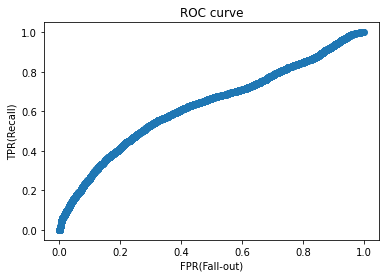

In [69]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

y_pred_proba = pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

## 2.4 하이퍼 파라미터 튜닝을 통해서 모델을 개선하세요
> `RandomSearchCV`, `GridSearchCV` 등을 활용해서 모델의 성능을 개선합니다. 범위 설정에 따라 시간이 매우 소요될 수 있습니다.

In [110]:
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder
from scipy.stats import randint, uniform
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

pipe = make_pipeline(
    TargetEncoder(min_samples_leaf=10, smoothing=1),
    SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)

dists = {
    'targetencoder__smoothing': [2.,20.,50.,60.,100.,500.,1000.], # int로 넣으면 error(bug)
    'targetencoder__min_samples_leaf': randint(1, 10),
    'simpleimputer__strategy': ['mean', 'median'],
    'xgbclassifier__n_estimators': [100, 200, 300]
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=5, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.1min finished


In [111]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

4  ...                                                  2
mean_fit_time                                                                    10.0655  ...                                            19.3964
std_fit_time                                                                    0.215787  ...                                           0.235333
mean_score_time                                                                  0.34094  ...                                            0.59362
std_score_time                                                                 0.0456014  ...                                          0.0410242
param_simpleimputer__strategy                                                       mean  ...                                             median
param_targetencoder__min_samples_leaf                                                  2  ...                                                  7
param_targetencoder__smoothing                                                        50  ...                                                 50
param_xgbclassifier__n_estimators                                                    100  ...                                                200
params                                 {'simpleimputer__strategy': 'mean', 'targetenc...  ...  {'simpleimputer__strategy': 'median', 'targete...
split0_test_score                                                                -0.2275  ...                                            -0.2286
split1_test_score                                                               -0.23435  ...                                           -0.23405
split2_test_score                                                               -0.22525  ...                                            -0.2286
mean_test_score                                                                -0.229033  ...                                          -0.230417
std_test_score                                                                0.00387004  ...                                         0.00256915
rank_test_score                                                                        1  ...                                                  5

[15 rows x 5 columns]

In [112]:
# 만들어진 모델에서 가장 성능이 좋은 모델을 불러옵니다.
pipe = clf.best_estimator_
y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)
print('훈련 정확도: ', accuracy_score(y_train, y_train_pred))
print('테스트 정확도: ', accuracy_score(y_test, y_test_pred))

print(classification_report(y_test_pred, y_test))

훈련 정확도:  0.8914333333333333
테스트 정확도:  0.77335
              precision    recall  f1-score   support

           0       0.90      0.83      0.87     17517
           1       0.24      0.37      0.29      2483

    accuracy                           0.77     20000
   macro avg       0.57      0.60      0.58     20000
weighted avg       0.82      0.77      0.79     20000



## Part 3: 시각화 (Visualization)

> 모델의 해석을 위한 시각화를 해주세요. 아래의 제시 된 종류 중 2가지를 선택하세요 (시각화에 가장 중요한 것은 **여러분의 분석**입니다.):
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [39]:
X_test

DBA Name  ...  Longitude
0          DUNKIN' DONUTS/JET BOX  ... -87.741646
1      WHALE FISH AND CHICKEN INC  ... -87.749790
2        NUMERO UNO SUPER MERCADO  ... -87.717258
3                KIKI'S CHOP SUEY  ... -87.651677
4                   LOTUS BANH MI  ... -87.632917
...                           ...  ...        ...
19995                      SUBWAY  ... -87.525872
19996    CONTE DI SAVOIA INC WEST  ... -87.682322
19997                   BAR LOUIE  ... -87.629577
19998                       KEN'S  ... -87.681630
19999   BRICK HOUSE BAR AND GRILL  ... -87.707720

[20000 rows x 14 columns]

In [74]:
X_test.columns

Index(['DBA Name', 'AKA Name', 'License #', 'Facility Type', 'Risk', 'Address',
       'City', 'State', 'Zip', 'Inspection Date', 'Inspection Type',
       'Violations', 'Latitude', 'Longitude'],
      dtype='object')

Permutation Importances

In [104]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.pipeline import Pipeline
import eli5
from eli5.sklearn import PermutationImportance

# pipeline 다시 정의
pipe = Pipeline([
    ('preprocessing', make_pipeline(
    TargetEncoder(min_samples_leaf=10, smoothing=1),
    SimpleImputer(strategy='median'))),
    ('XGB', XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )) 
], verbose=1)

pipe.fit(X_train, y_train);

# permuter 정의
permuter = PermutationImportance(
    pipe.named_steps['XGB'], # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_test을 사용합니다.
X_test_transformed = pipe.named_steps['preprocessing'].transform(X_test)

permuter.fit(X_test_transformed, y_test);

[Pipeline] ..... (step 1 of 2) Processing preprocessing, total=   1.0s
[Pipeline] ............... (step 2 of 2) Processing XGB, total=  13.8s


In [108]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=list(X_test.columns) # list 형식으로 넣어야 합니다
)

Partial Dependence Plot, 1 feature isolation

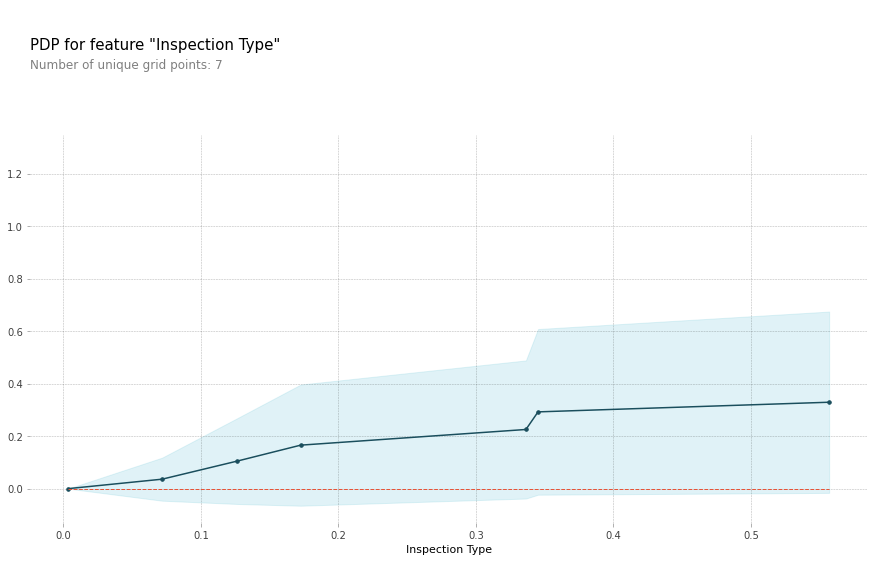

In [84]:
# 이 곳에 답안을 작성해주시길 바랍니다
pipe = make_pipeline(
    TargetEncoder(min_samples_leaf=10, smoothing=1),
    # SimpleImputer(strategy='median'),
    XGBClassifier(n_estimators=200
                  , random_state=2
                  , n_jobs=-1
                  , max_depth=7
                  , learning_rate=0.2
                 )
)
pipe.fit(X_train, y_train)

from pdpbox.pdp import pdp_isolate, pdp_plot
encoder = pipe.named_steps['targetencoder']
X_encoded = encoder.fit_transform(X_train, y_train)
XGB = pipe.named_steps['xgbclassifier']

feature = 'Inspection Type'
pdp_dist = pdp_isolate(model=XGB, dataset=X_encoded, model_features=X_train.columns, feature=feature)
pdp_plot(pdp_dist, feature); 

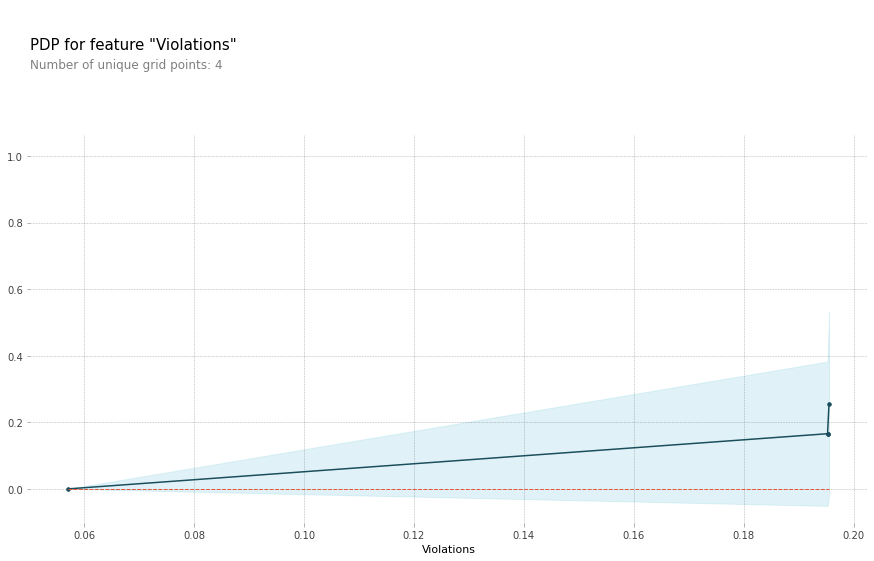

In [87]:
feature = 'Violations'
pdp_dist = pdp_isolate(model=XGB, dataset=X_encoded, model_features=X_train.columns, feature=feature)
pdp_plot(pdp_dist, feature); 

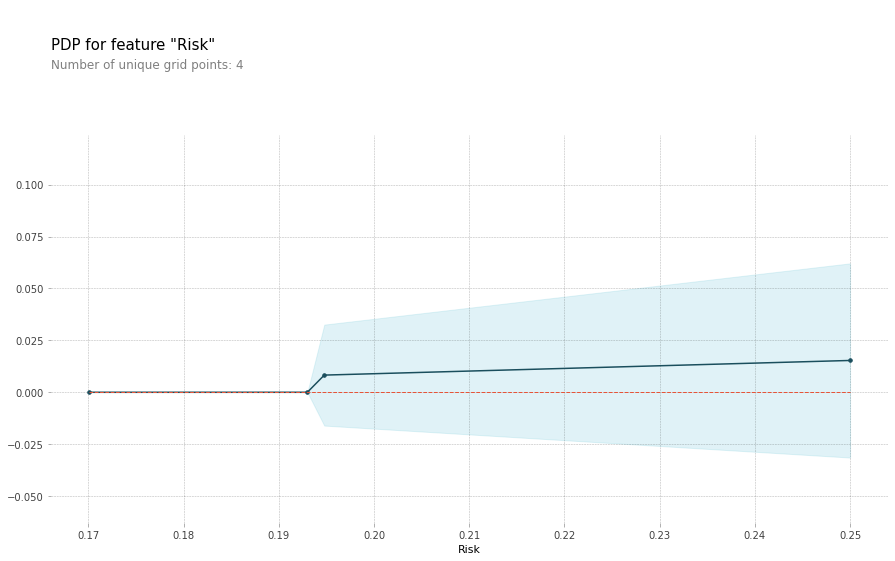

In [86]:
feature = 'Risk'
pdp_dist = pdp_isolate(model=XGB, dataset=X_encoded, model_features=X_train.columns, feature=feature)
pdp_plot(pdp_dist, feature); 

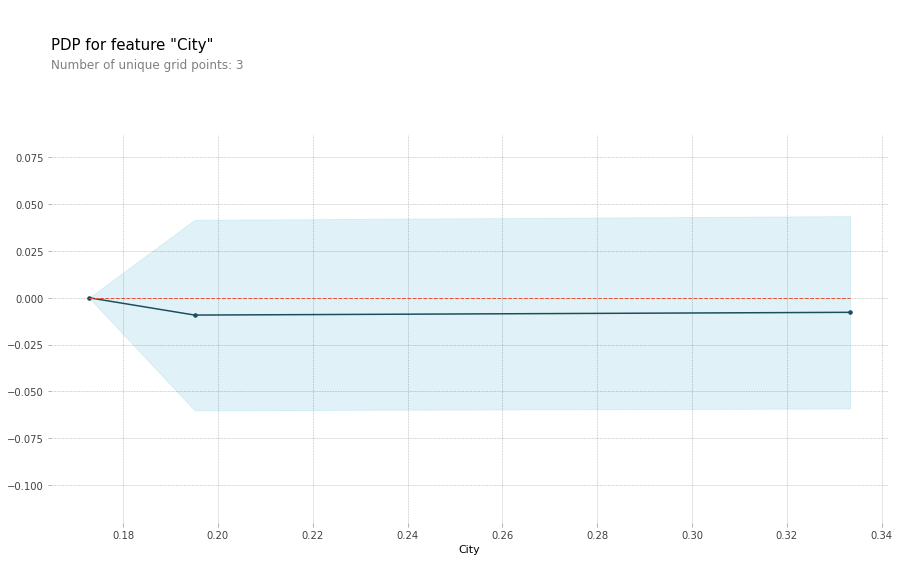

In [85]:
feature = 'City'
pdp_dist = pdp_isolate(model=XGB, dataset=X_encoded, model_features=X_train.columns, feature=feature)
pdp_plot(pdp_dist, feature); 

Partial Dependence Plot, 2 features interaction

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


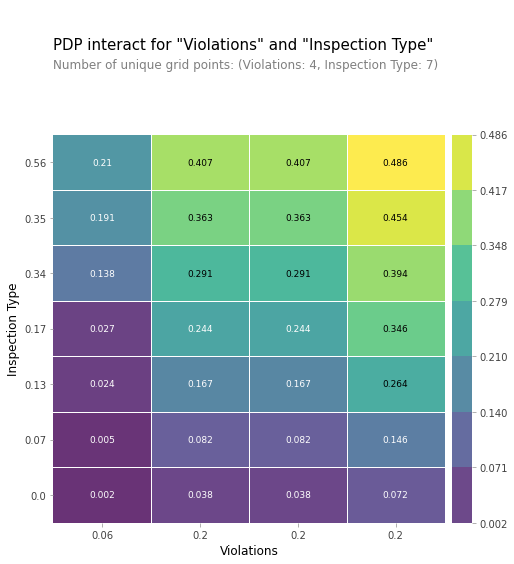

In [91]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
features = ['Violations', 'Inspection Type']

interaction = pdp_interact(
    model=XGB, 
    dataset=X_encoded, 
    model_features=X_train.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

Shapley Values

In [94]:
import shap
row = X_encoded.iloc[[1]]

explainer = shap.TreeExplainer(XGB)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

In [95]:
row = X_encoded.iloc[[2]]

explainer = shap.TreeExplainer(XGB)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values,
    features=row
)

shap summary_plot

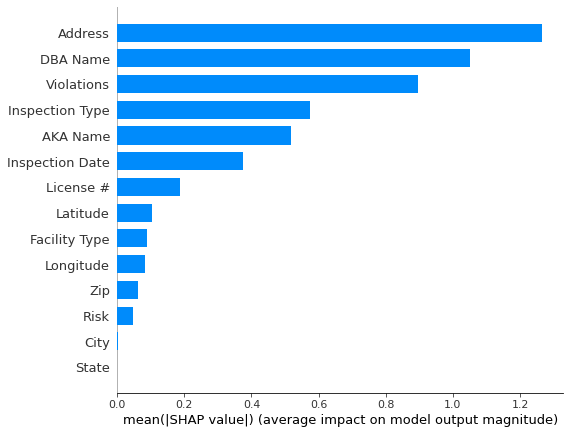

In [97]:
shap_values = explainer.shap_values(X_encoded.iloc[:100])
shap.summary_plot(shap_values, X_encoded.iloc[:100], plot_type= 'bar')

feature_importances

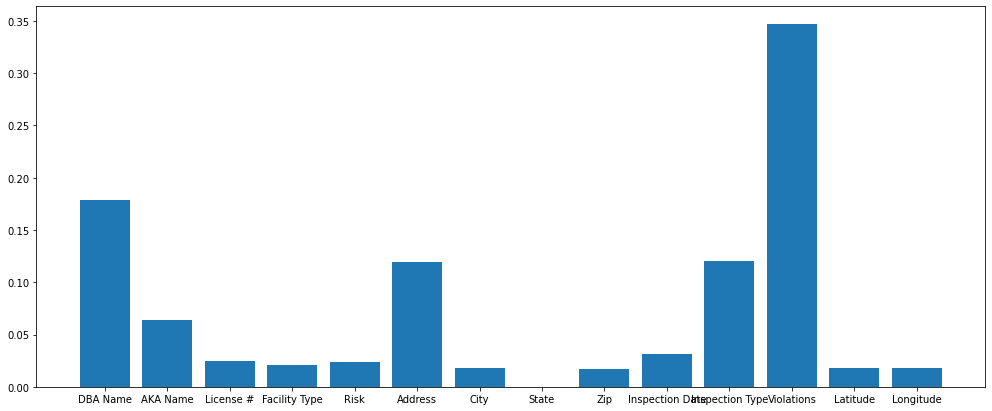

In [103]:
plt.figure(figsize = (17, 7))
plt.bar(x = X_test.columns, height = XGB.feature_importances_);